# Clustering Exercise
*(Adapted from Eytan Adar's SI 370 — University of Michigan)*

## Objectives:
- Be able to perform hierarchical clustering and k-means clustering.
- Know how and when to use different similarity functions, including Euclidean, Manhattan, Jaccard, and Cosine.
- Be able to appropriately evaluate clustering results, with or without ground truth.
- Be able to determine the number of clusters given a dataset without ground truth.

In [ ]:
# Filter all warnings.
# spurious warnings.
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import scipy as sp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn as sk
import sklearn.cluster as skc
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt

# 1. Hierarchical Clustering

Let's start with a toy dataset that has two dimensions. There are three obvious clusters.

Reference: https://github.com/herrfz/dataanalysis

In [ ]:
np.random.seed(0)
x = np.random.randn(12) * 0.2 + np.repeat(np.arange(3)+1, 4)
y = np.random.randn(12) * 0.2 + np.repeat(np.array([1,2,1]), 4)
df_xy = pd.DataFrame({'n': range(12),'x': x, 'y': y})
df_xy


,n,x,y
0,0,1.352810,1.152208
1,1,1.080031,1.024335
2,2,1.195748,1.088773
3,3,1.448179,1.066735
4,4,2.373512,2.298816
5,5,1.804544,1.958968
6,6,2.190018,2.062614
7,7,1.969729,1.829181
8,8,2.979356,0.489402
9,9,3.082120,1.130724


In [ ]:
points = alt.Chart(df_xy).mark_point().encode(
  x='x', y='y'
)
text = alt.Chart(df_xy).mark_text(dx=9).encode(
  x='x', y='y', text='n'
)
(points + text)

alt.LayerChart(...)

In [ ]:
# To perform hierarchical clustering, the first step is to compute 
# the distance matrix. We will be using the Euclidean distance.
df_xy_features = df_xy[["x","y"]] # Pull out only using the x & y colums to use for clustering
dist_xy = spd.squareform(spd.pdist(df_xy_features, metric='euclidean'))
dist_xy.shape

(12, 12)

In [ ]:
# The matrix may be too large to display. So let's display a top-left
# portion of it.
dist_xy[:4,:4]

array([[0.        , 0.30126365, 0.16938929, 0.12806509],
       [0.30126365, 0.        , 0.13244787, 0.37058077],
       [0.16938929, 0.13244787, 0.        , 0.25339119],
       [0.12806509, 0.37058077, 0.25339119, 0.        ]])

Notice that in the matrix above, the diagnonal values are 0, which is
expected: an object's distance to itself must be 0.

Before performing hierarchical clustering, let us review an important concept, "linkage function."
 - For hierarchical clustering, a _linkage function_ is a distance function between two clusters. In scipy multiple different linkage functions are implemented, including single, complete, average, weighted, centroid, median, and ward. We will be using "single", which is taking the distance between two nearest points as the distance between two clusters. This is the default option. See [scipy documentation](http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.cluster.hierarchy.linkage.html) for more details.

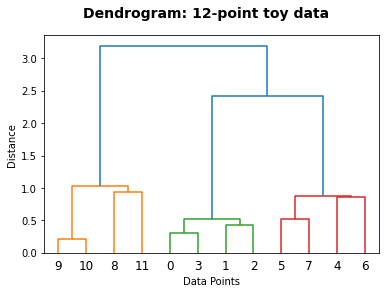

In [ ]:
# Perform hierarchical clustering and plot the dendrogram.
Z_xy = sph.linkage(dist_xy, method='single')  # obtain the linkage matrix
_ = sph.dendrogram(Z_xy)  # plot the linkage matrix as a dendrogram
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.suptitle('Dendrogram: 12-point toy data', 
             fontweight='bold', fontsize=14);

In the above dendrogram, the y-axis depicts the distance at which a cluster is formed. This distance is obtained by evaluating the linkage function. We can see that the green cluster forms at around 1.0, then the next cluster forms at around 2.4. There is a large gap (on the y-axis) in between, which indicates that segmenting the data there may be a good choice. In fact, the scipy package automatically selects a threshold, below which the clusters are colored differently, and above which the clusters are all colored blue. This happens to match our interpretation.

Based on the above analysis, 2.0 seems to be a good distance threshold to "clip" the dendrogram and obtain our clustering results. The way to apply the clipping threshold is as follows:

In [ ]:
cluster_labels = sph.fcluster(Z_xy,2, criterion='distance')
df_xy['cluster_label'] = cluster_labels
df_xy

,n,x,y,cluster_label
0,0,1.352810,1.152208,2
1,1,1.080031,1.024335,2
2,2,1.195748,1.088773,2
3,3,1.448179,1.066735,2
4,4,2.373512,2.298816,3
5,5,1.804544,1.958968,3
6,6,2.190018,2.062614,3
7,7,1.969729,1.829181,3
8,8,2.979356,0.489402,1
9,9,3.082120,1.130724,1


Compare the cluster_labels with the scatterplot at the beginning, we can see that hierarchical clustering indeed captures the actual clusters as expected.

## A (Slightly) More Complex Example:
- Step 1: Import the [Iris Dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) and create a scatterplot, showing petal_lengths and petal_widths.
- Step 2: Compute the distance matrix among irises using petal_lengths and petal_widths. Use Euclidean distance.
- Step 3: Perform hierarchical clustering.
- Step 4: Pick a distance threshold that results in 3 clusters that match the actual number of species.

In [ ]:
# Step 1: Import the iris dataset and create scatterplot.
# Show only petal_length and petal_width.
from vega_datasets import data
df_iris = data.iris()
alt.Chart(df_iris).mark_point().encode(
  x='petalLength', y='petalWidth', color='species'
)

alt.Chart(...)

In [ ]:
# Step 2: Compute distance matrix. Using petal_length and petal_width only --- what happens if you try different distance metrics?
# plpw means "petal_length and petal_width"
dist_iris_plpw = spd.squareform(spd.pdist(
        df_iris[['petalLength', 'petalWidth']], 
        metric='euclidean'))
dist_iris_plpw.shape

(150, 150)

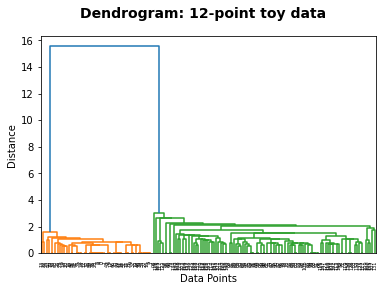

In [ ]:
# Perform hierarchical clustering and plot the dendrogram.
iris_xy = sph.linkage(dist_iris_plpw, method='single')  # obtain the linkage matrix --- what happens if you try different linkage functions?
_ = sph.dendrogram(iris_xy)  # plot the linkage matrix as a dendrogram
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.suptitle('Dendrogram: 12-point toy data', 
             fontweight='bold', fontsize=14);

In [ ]:
# Add  labels back to the dataframe
iris_labels = sph.fcluster(iris_xy, 2.8, criterion='distance') # --- what happens if you use a different distance threshold?
df_iris['cluster_label'] = iris_labels
df_iris.head()

,sepalLength,sepalWidth,petalLength,petalWidth,species,cluster_label
0,5.1,3.5,1.4,0.2,setosa,1
1,4.9,3.0,1.4,0.2,setosa,1
2,4.7,3.2,1.3,0.2,setosa,1
3,4.6,3.1,1.5,0.2,setosa,1
4,5.0,3.6,1.4,0.2,setosa,1


In [ ]:
# Plot
alt.Chart(df_iris).mark_point().encode(
  x='petalLength', y='petalWidth', color='cluster_label:N'
)

alt.Chart(...)

# 2. k-means

In [ ]:
# Let's first revisit the 12-point toy dataset.
(points + text)

alt.LayerChart(...)

In [ ]:
# We also have this dataframe with only the columns we'll cluster on
df_xy_features.head()

,x,y
0,1.352810,1.152208
1,1.080031,1.024335
2,1.195748,1.088773
3,1.448179,1.066735
4,2.373512,2.298816


In [ ]:
# Perform k-means using the scikit-learn package
kmeans_model = skc.KMeans(n_clusters=3,)
kmeans_model.fit(df_xy_features)
centroids = kmeans_model.cluster_centers_
centroids  # these are the centers of the clusters

array([[2.08445057, 2.03739464],
       [1.26919204, 1.08301252],
       [3.09528484, 0.911145  ]])

In [ ]:
# See cluster_labels
kmeans_model.labels_

array([1, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2], dtype=int32)

In [ ]:
kmeans_centroids = pd.DataFrame(centroids)
kmeans_centroids

,0,1
0,2.084451,2.037395
1,1.269192,1.083013
2,3.095285,0.911145


In [ ]:
# Plot the clusters with their centroids.
df_xy['cluster_labels_kmeans'] = kmeans_model.labels_
points_plot_color = alt.Chart(df_xy).mark_point().encode(
  x='x', y='y', color='cluster_labels_kmeans:N'
)
centroid_plot = alt.Chart(kmeans_centroids).mark_point(shape='diamond',color='black').encode(
    x='0:Q', y='1:Q'
)
(points_plot_color + centroid_plot + text)

alt.LayerChart(...)

# 2.5 Determining the Number of Clusters

A number of clustering methods, such as k-means, assumes the parameter _k_ (#clusters) is known in advance, which is often not the case in practice. A number of techniques exist for determining the number of clusters in a dataset. See [this Wikipedia page](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#Information_Criterion_Approach) for a detailed discussion.

In this section, we focus on four of the approaches:
1. Rule of thumb
2. The Elbow Method

For this section, let us use `df_xy`, the dataset we created in Section 1. Obviously, there are 3 natural clusters in the dataset. Let us see if all the methods listed above will be able to recover the true number of clusters.

## 4.1 Rule of thumb:
Choosing the number of clusters to simply be

$$
k \approx \sqrt{n/2}
$$

where $n$ is the number of observations.

In [ ]:
# Recall df_xy used in the first section.
(points+text)

alt.LayerChart(...)

In [ ]:
# To determine the natural cluster
np.sqrt(len(df_xy) / 2)

2.449489742783178

In [ ]:
# Round this number to an integer
np.round(np.sqrt(len(df_xy) / 2))

2.0

This is not what we desired. We wanted k to be 3.

## 4.2 The Elbow Method
See [here](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_Elbow_Method) for an explanation.

Implementation Reference: https://github.com/nborwankar/LearnDataScience

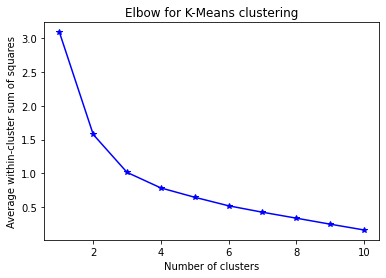

In [ ]:
X = df_xy.iloc[:,:2]  # Using the the dataset of Section 1
K = range(1,11)  # Apply kmeans 1 to 10
kmeans_models = [skc.KMeans(k).fit(X) for k in K]
centroids = [m.cluster_centers_ for m in kmeans_models]
D_k = [spd.cdist(X, cent, 'euclidean') for cent in centroids]
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

# plot elbow curve
plt.plot(K, avgWithinSS, 'b*-')
plt.xlabel('Number of clusters');
plt.ylabel('Average within-cluster sum of squares');
plt.title('Elbow for K-Means clustering');

According to the graph above, the "within-cluster sum of squares" (i.e., within-cluster variance) reduces as the number of clusters (k) grows. However, as k grows larger, the marginal reduction drops. At some point, this drop is so obvious that it forms a visible "angle" in the graph. The number of clusters is then chosen at this point, hence the "elbow" criterion". The "elbow" is not always easily identifiable.

In the above plot, we can manually identify k=3 as the "elbow" point.

# With the World Development Indicators
Try some different clustering approaches with the World Bank dataset. What happens if you change the set of columns included in the clustering? The number of clusters? What plot you visualize them on?

In [ ]:
worldbank_data_url = 'https://drive.google.com/uc?export=download&id=1EtNlb935g5Jo3Hvsc5OUiYMJcCJCXY0l'
df_wdi = pd.read_csv(worldbank_data_url)
df_wdi = df_wdi.dropna()
df_wdi.head()

,Country,Fertility rate (births/woman),Life expectancy at birth (years),GDP (USD),Population density (people/km2),GDP per capita growth (%/yr),Income per capita (USD),CO2 emissions (tons per capita)
0,Qatar,2.070,79.108,1.251223e+11,159.890353,6.618785,41865.062795,39.059708
1,Cameroon,5.111,55.101,2.614382e+10,43.031121,0.619380,1059.839636,0.333327
2,Ethiopia,5.136,61.627,2.993379e+10,87.639964,9.460597,259.077562,0.075148
3,Mauritania,4.980,62.527,4.337794e+09,3.390118,1.751621,836.635449,0.640167
4,Saudi Arabia,2.970,73.917,5.282072e+11,12.756007,2.008917,15762.798652,18.908248


In [ ]:
# Choose which set of columns to cluster by
country = df_wdi['Country'].dropna()  # Extract the country name
df_wdi_cluster_cols = df_wdi[['Fertility rate (births/woman)', 
                              'Life expectancy at birth (years)',
                              'Income per capita (USD)']]

In [ ]:
# Scaling -- what happens if you cluster with and without scaling?
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
df_scaled = scale.fit_transform(df_wdi_cluster_cols)
df_scaled = pd.DataFrame(df_scaled) 
df_scaled.columns = [df_wdi_cluster_cols[:0]]
df_scaled.head()

,Fertility rate (births/woman),Life expectancy at birth (years),Income per capita (USD)
0,-0.617431,1.116694,2.449841
1,1.498633,-1.729165,-0.630877
2,1.516029,-0.955554,-0.691333
3,1.407477,-0.848866,-0.647728
4,0.008829,0.501338,0.479169


In [ ]:
# Clustering --- try different numbers of clusters or swap out for a hierarchical approach
kmeans_model = skc.KMeans(n_clusters=3)
kmeans_model.fit(df_scaled)
centroids = kmeans_model.cluster_centers_
centroids

array([[ 1.37224121, -1.31781791, -0.62334865],
       [-0.83795703,  1.20225815,  1.94732035],
       [-0.45115753,  0.30524492, -0.29958099]])

In [ ]:
unscaled_centroids = scale.inverse_transform(centroids)
unscaled_centroids

array([[4.92936218e+00, 5.85710277e+01, 1.15955242e+03],
       [1.75308179e+00, 7.98298029e+01, 3.52089978e+04],
       [2.30895214e+00, 7.22628081e+01, 5.44797273e+03]])

In [ ]:
# Plot --- try visualizing on different scatterplots
df_wdi['cluster_labels_kmeans'] = kmeans_model.labels_

wdi_points_plot = alt.Chart(df_wdi).mark_point().encode(
  x='Fertility rate (births/woman)', y='Life expectancy at birth (years)', color='cluster_labels_kmeans:N'
)
wdi_centroid_plot = alt.Chart(pd.DataFrame(unscaled_centroids)).mark_point(shape='diamond',color='black').encode(
    x='0:Q', y='1:Q'
)
(wdi_points_plot + wdi_centroid_plot)

alt.LayerChart(...)

# Bonus - Distance Metrics

In [ ]:
traits = [
    ('Alice', ['Accessible', 'Confident', 'Creative', 'Sweet']),
    ('Bob', ['Strong', 'Confident', 'Creative','Tidy']),
    ('Charlie', ['Confident', 'Strong', 'Accessible', 'Sweet']),
    ('Dacy', ['Accessible', 'Strong', 'Tidy', 'Confident']),
    ('Emily', ['Reserved', 'Cute', 'Quiet', 'Impassive']),
    ('Fred', ['Cute', 'Impassive', 'Gentle','Confident']),
    ('George', ['Cute', 'Quiet', 'Reserved', 'Confident'])
]

In [ ]:
# In order to make computation easier, let's create dummy variables 
# for traits. You should be able to understand what is going on below.

# First, obtain a unique list of traits.
all_traits = sorted({t for x in traits for t in x[1]})

# Second, create dummy variables.
traits_dummy = []
for name, ts in traits:
    tis = [0] * len(all_traits)
    for t in ts:
        tis[all_traits.index(t)] = 1
    traits_dummy.append(tis)

# Third, create a DataFrame.
names = [x[0] for x in traits]
df_traits = pd.DataFrame(traits_dummy, columns=all_traits, index=names)
df_traits

,Accessible,Confident,Creative,Cute,Gentle,Impassive,Quiet,Reserved,Strong,Sweet,Tidy
Alice,1,1,1,0,0,0,0,0,0,1,0
Bob,0,1,1,0,0,0,0,0,1,0,1
Charlie,1,1,0,0,0,0,0,0,1,1,0
Dacy,1,1,0,0,0,0,0,0,1,0,1
Emily,0,0,0,1,0,1,1,1,0,0,0
Fred,0,1,0,1,1,1,0,0,0,0,0
George,0,1,0,1,0,0,1,1,0,0,0


In [ ]:
kmeans_model = skc.KMeans(n_clusters=3)
kmeans_model.fit(df_traits)
centroids = kmeans_model.cluster_centers_
centroids

array([[5.00000000e-01, 1.00000000e+00, 5.00000000e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 5.00000000e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.00000000e-01, 1.00000000e+00, 0.00000000e+00],
       [5.55111512e-17, 6.66666667e-01, 0.00000000e+00, 1.00000000e+00,
        3.33333333e-01, 6.66666667e-01, 6.66666667e-01, 6.66666667e-01,
        5.55111512e-17, 0.00000000e+00, 0.00000000e+00]])

In [ ]:
kmeans_model.labels_

array([1, 0, 1, 0, 2, 2, 2], dtype=int32)

Let's try different distance measures between Alice and Bob.
We've copied their traits down here:

 ('Alice', ['Accessible', 'Confident', 'Creative', 'Sweet']),

 ('Bob', ['Strong', 'Confident', 'Creative','Sporting']),

Notice they have 4 traits each and they share 2 traits in common.

In [ ]:
# (1) Euclidean distance:
#     by definition, this will be sqrt(1^2 + 1^2 + 1^2 + 1^2)
spd.euclidean(df_traits.loc['Alice'], df_traits.loc['Bob'])

2.0

In [ ]:
# (2) Jaccard distance:
#     by definition, this will be 1 - (2 / 6)
spd.jaccard(df_traits.loc['Alice'], df_traits.loc['Bob'])

0.6666666666666666

In [ ]:
# (3) Manhattan (cityblock) distance:
#     by definition, this will be 1 + 1 + 1 + 1
spd.cityblock(df_traits.loc['Alice'], df_traits.loc['Bob'])

4

In [ ]:
# (4) Cosine distance
#     by definition, this will be 1 - 2 / (2 * 2)
spd.cosine(df_traits.loc['Alice'], df_traits.loc['Bob'])

0.5

In [ ]:
# As we have seen in Section 1, you can compute pairwise distance like
# below, using any of the distance measurements. 
dist_traits = spd.squareform(spd.pdist(df_traits, 'cosine'))
dist_traits[:4,:4]  # to save space, only show the top left 4x4 block

array([[0.  , 0.5 , 0.25, 0.5 ],
       [0.5 , 0.  , 0.5 , 0.25],
       [0.25, 0.5 , 0.  , 0.25],
       [0.5 , 0.25, 0.25, 0.  ]])